### Importing libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Bidirectional,Dense,SpatialDropout1D,Embedding,GRU
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cleaned_dataset_02_drugs.csv',index_col=0)

In [5]:
data.head()

,review,sentiment
0,stuffy nose retire physician med try allergy s...,2
1,cold symptom clear right even throat hurting g...,2
2,prothrombin time international normalize ratio...,1
3,fall realise,0
4,grandfather prescribe medication coumadin assi...,0


In [6]:
data.review=data.review.astype(str)

<Axes: xlabel='sentiment', ylabel='count'>

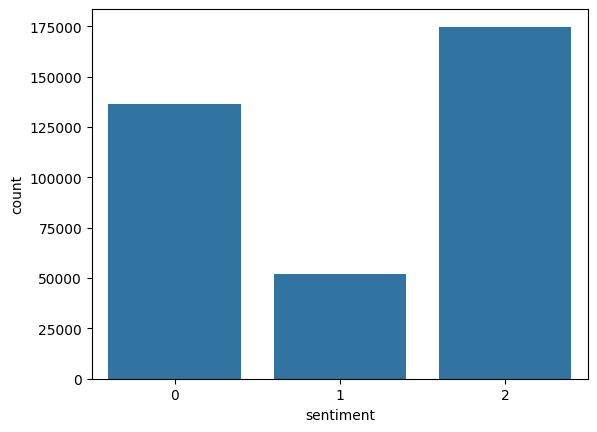

In [7]:
sns.countplot(x=data.sentiment,data=data)

In [8]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data.review)

In [9]:
vocabulary_size=len(tokenizer.word_index)+1

In [10]:
vocabulary_size

87837

In [11]:
seq=tokenizer.texts_to_sequences(data.review)

In [12]:
num_tokens=[len(sentence)for sentence in seq]
num_tokens=np.array(num_tokens)

## Maximum review length

In [13]:
max(num_tokens)

338

In [14]:
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens

99.89444541175388

In [15]:
max_tokens=100

In [16]:
np.sum(num_tokens<max_tokens)/len(num_tokens) ##99% data lies within it

0.9507477825614792

In [17]:
pad_seq=pad_sequences(seq,maxlen=max_tokens,padding='post')

In [18]:
pad_seq

array([[  319,   139,  2159, ...,     0,     0,     0],
       [  329,   107,   278, ...,     0,     0,     0],
       [14188,    29,  7916, ...,     0,     0,     0],
       ...,
       [   62,   522,    90, ...,     0,     0,     0],
       [   62,   522,    34, ...,     0,     0,     0],
       [   62,   522,    53, ...,     0,     0,     0]], dtype=int32)

In [19]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,stratify=data.sentiment)

In [20]:
x_train.shape

(272104, 100)

In [21]:
x_test.shape

(90702, 100)

In [22]:
from gensim.models import FastText

In [23]:
modelf=FastText.load('/content/drive/MyDrive/Colab Notebooks/Fasttext_model2')

### Generating word embeddings with FASTTEXT

In [24]:
embedding_matrix=np.zeros((vocabulary_size,100))
for word,i in tokenizer.word_index.items():
  if word in modelf.wv:
    embedding_matrix[i]=modelf.wv[word]


In [25]:
modelf.wv['birth']

array([-0.05843591, -0.34096628, -0.91325855, -0.44902545,  0.06130463,
       -0.429203  ,  0.58045423,  0.05346946, -0.13164623, -0.5473678 ,
       -0.3240666 ,  0.270965  ,  0.26555505, -0.27948517,  0.2601419 ,
       -0.2623356 , -0.1392521 ,  0.21500042, -0.48749638,  0.09647668,
        0.7220927 ,  0.32468572,  0.05849307, -0.52573866,  0.06253142,
       -0.03097827,  0.0120508 , -0.23107259,  0.2393989 , -0.26035473,
        0.20316839,  0.3148518 ,  0.43808916, -0.21598192,  0.1593785 ,
        0.6419307 , -0.27310532,  0.12018342, -0.6400227 ,  0.1284779 ,
        0.5414073 ,  0.12494288,  0.3508112 , -0.37819782, -0.07378837,
        0.21322623, -0.0197391 ,  0.2560009 ,  0.26659703, -0.16103306,
        0.30423552,  0.01076972, -0.06244149,  0.5317932 , -0.36071107,
        0.13927753, -0.18428026,  0.2847531 ,  0.0118041 ,  0.4975654 ,
       -0.02323597,  0.0077946 ,  0.11051185,  0.67663443,  0.41309294,
       -0.17136033, -0.00404761,  0.1232084 , -0.14446501,  0.19

## LSTM without balancing with FastText"

In [ ]:
model1=Sequential()
model1.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model1.add(SpatialDropout1D(0.1))
model1.add(LSTM(units=128,activation='tanh'))
#output layer
model1.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model1.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          8783700   
                                                                 
 spatial_dropout1d (Spatial  (None, 100, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 8901335 (33.96 MB)
Trainable params: 117635 (459.51 KB)
Non-trainable params: 8783700 (33.51 MB)
_________________________________________________________________


In [ ]:
history=model1.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=100)

Epoch 1/60
2722/2722 [==============================] - 36s 10ms/step - loss: 0.9932 - accuracy: 0.4924 - val_loss: 0.9085 - val_accuracy: 0.5972
Epoch 2/60
2722/2722 [==============================] - 26s 10ms/step - loss: 0.8247 - accuracy: 0.6511 - val_loss: 0.7767 - val_accuracy: 0.6784
Epoch 3/60
2722/2722 [==============================] - 26s 9ms/step - loss: 0.7637 - accuracy: 0.6823 - val_loss: 0.7406 - val_accuracy: 0.6921
Epoch 4/60
2722/2722 [==============================] - 25s 9ms/step - loss: 0.7340 - accuracy: 0.6954 - val_loss: 0.7229 - val_accuracy: 0.6999
Epoch 5/60
2722/2722 [==============================] - 27s 10ms/step - loss: 0.7145 - accuracy: 0.7033 - val_loss: 0.7140 - val_accuracy: 0.7016
Epoch 6/60
2722/2722 [==============================] - 25s 9ms/step - loss: 0.6985 - accuracy: 0.7099 - val_loss: 0.7045 - val_accuracy: 0.7060
Epoch 7/60
2722/2722 [==============================] - 27s 10ms/step - loss: 0.6848 - accuracy: 0.7163 - val_loss: 0.7004 - va

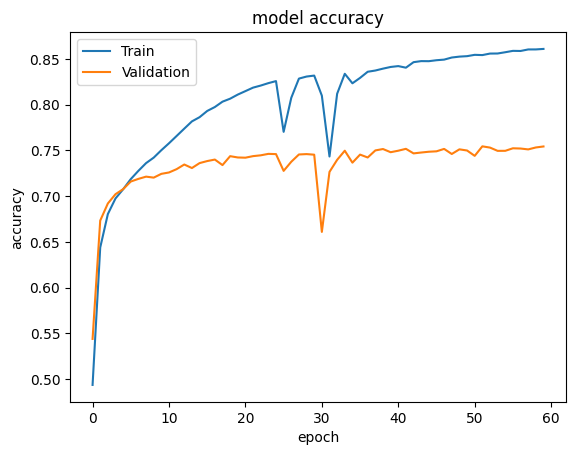

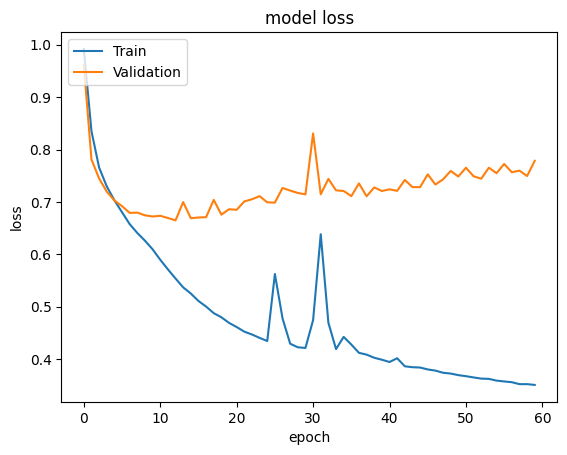

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model1.evaluate(x_test,y_test)

2835/2835 [==============================] - 13s 5ms/step - loss: 0.7785 - accuracy: 0.7543


In [ ]:
print(f"Accuracy:{accuracy}\n Loss:{loss}")

Accuracy:0.7543053030967712
 Loss:0.7785294055938721


In [ ]:
y_pred=model1.predict(x_test)

2835/2835 [==============================] - 10s 4ms/step


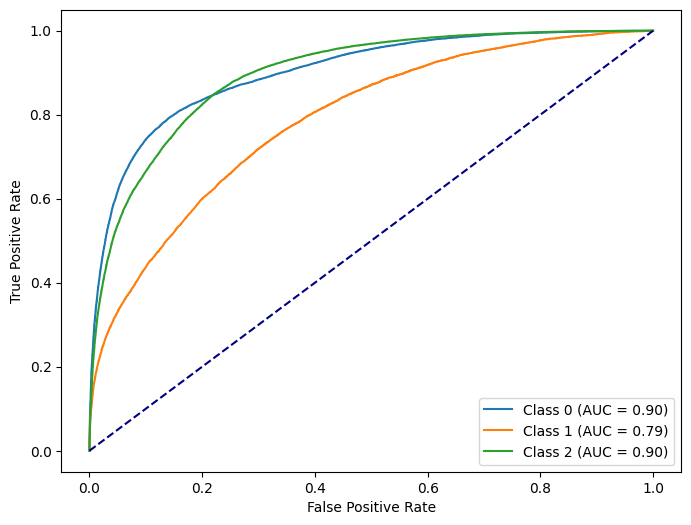

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     34040
           1       0.54      0.32      0.40     13072
           2       0.76      0.88      0.81     43590

    accuracy                           0.75     90702
   macro avg       0.70      0.65      0.66     90702
weighted avg       0.74      0.75      0.74     90702



In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[26116  1734  6190]
 [ 3183  4155  5734]
 [ 3659  1785 38146]]


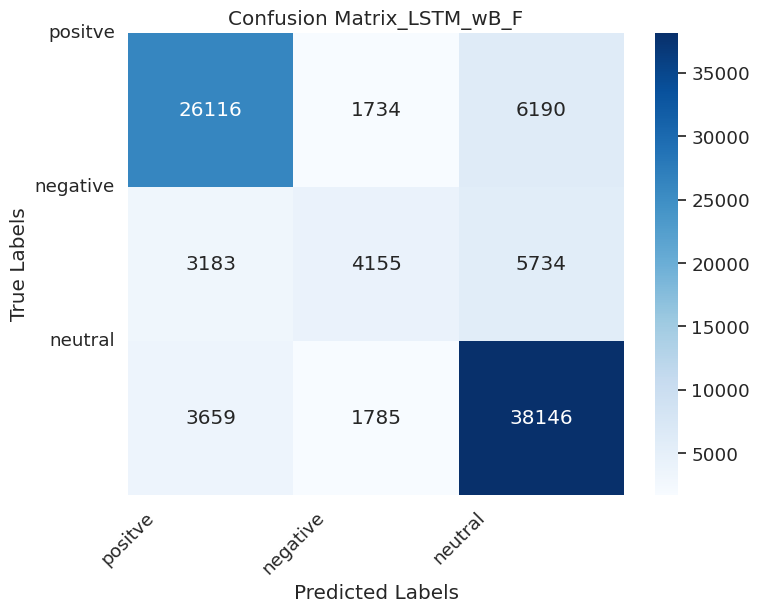

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## Bi_LSTM without Balancing and Fasttext

In [ ]:
model=Sequential()
model.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional((LSTM(units=250,activation='tanh'))))
#output layer
model.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          8783700   
                                                                 
 spatial_dropout1d_1 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 bidirectional (Bidirection  (None, 500)               702000    
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 3)                 1503      
                                                                 
Total params: 9487203 (36.19 MB)
Trainable params: 703503 (2.68 MB)
Non-trainable params: 8783700 (33.51 MB)
_________________________________________________________________


In [ ]:
history=model.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
2722/2722 [==============================] - 56s 19ms/step - loss: 0.8396 - accuracy: 0.6358 - val_loss: 0.7858 - val_accuracy: 0.6620
Epoch 2/60
2722/2722 [==============================] - 49s 18ms/step - loss: 0.7683 - accuracy: 0.6749 - val_loss: 0.7521 - val_accuracy: 0.6843
Epoch 3/60
2722/2722 [==============================] - 43s 16ms/step - loss: 0.7392 - accuracy: 0.6899 - val_loss: 0.7238 - val_accuracy: 0.6976
Epoch 4/60
2722/2722 [==============================] - 49s 18ms/step - loss: 0.7171 - accuracy: 0.6998 - val_loss: 0.7169 - val_accuracy: 0.6986
Epoch 5/60
2722/2722 [==============================] - 48s 18ms/step - loss: 0.6994 - accuracy: 0.7075 - val_loss: 0.7043 - val_accuracy: 0.7071
Epoch 6/60
2722/2722 [==============================] - 48s 18ms/step - loss: 0.6838 - accuracy: 0.7153 - val_loss: 0.6958 - val_accuracy: 0.7108
Epoch 7/60
2722/2722 [==============================] - 43s 16ms/step - loss: 0.6698 - accuracy: 0.7211 - val_loss: 0.6888 -

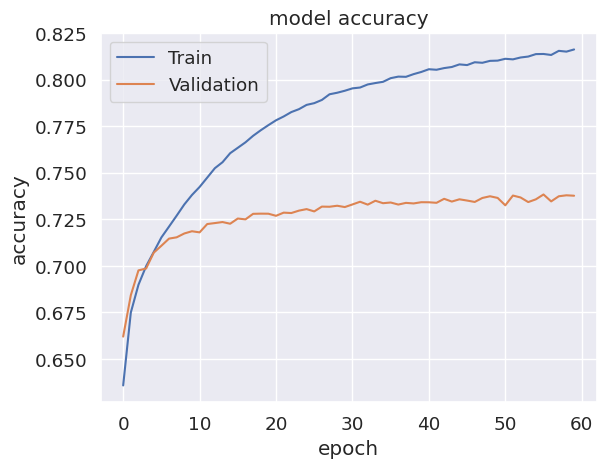

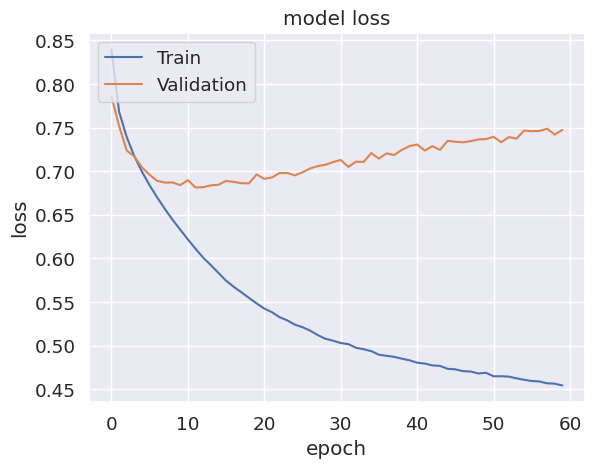

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model.evaluate(x_test,y_test)

2835/2835 [==============================] - 15s 5ms/step - loss: 0.7473 - accuracy: 0.7377


In [ ]:
print(f"Accuracy:{accuracy}\n Loss:{loss}")

Accuracy:0.7376904487609863
 Loss:0.7473205327987671


In [ ]:
y_pred=model.predict(x_test)

2835/2835 [==============================] - 13s 5ms/step


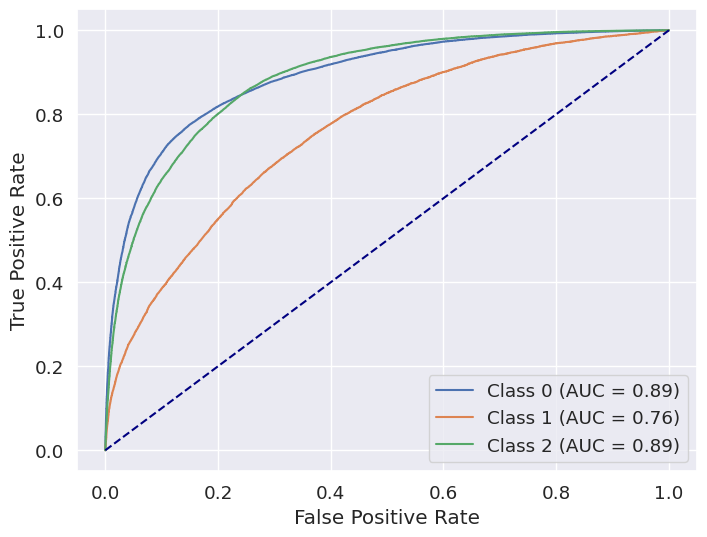

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.76      0.76     34040
           1       0.48      0.27      0.35     13072
           2       0.75      0.86      0.80     43590

    accuracy                           0.74     90702
   macro avg       0.67      0.63      0.64     90702
weighted avg       0.72      0.74      0.72     90702



In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[25781  1885  6374]
 [ 3621  3552  5899]
 [ 4061  1952 37577]]


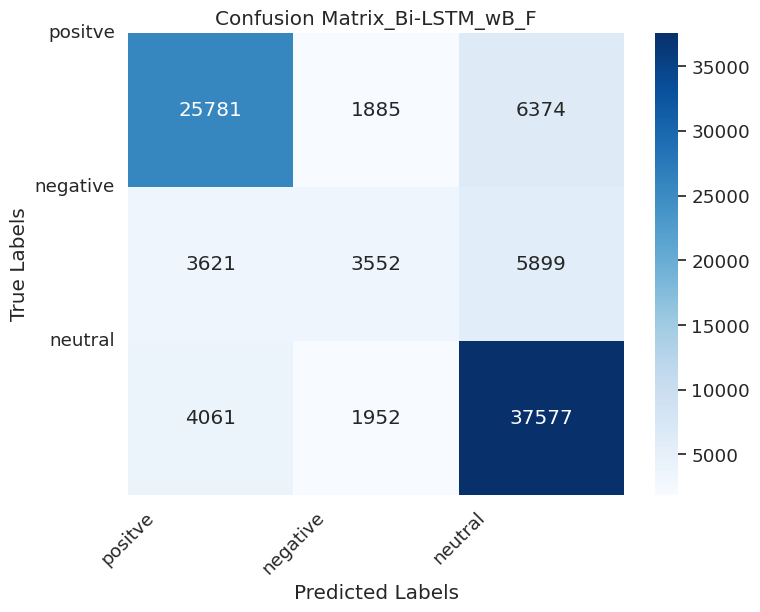

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_Bi-LSTM_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

### LSTM+GRU withou balancing and Fasttext

In [ ]:
modell=Sequential()
modell.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
modell.add(SpatialDropout1D(0.1))
modell.add(LSTM(units=200,activation='tanh',return_sequences=True))
modell.add(GRU(units=200,activation='tanh'))
modell.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
modell.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
modell.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          8783700   
                                                                 
 spatial_dropout1d_4 (Spati  (None, 100, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 100, 200)          240800    
                                                                 
 gru (GRU)                   (None, 200)               241200    
                                                                 
 dense_4 (Dense)             (None, 3)                 603       
                                                                 
Total params: 9266303 (35.35 MB)
Trainable params: 482603 (1.84 MB)
Non-trainable params: 8783700 (33.51 MB)
___________

In [ ]:
history=modell.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

Epoch 1/60
2722/2722 [==============================] - 62s 17ms/step - loss: 0.9141 - accuracy: 0.5711 - val_loss: 0.7917 - val_accuracy: 0.6645
Epoch 2/60
2722/2722 [==============================] - 46s 17ms/step - loss: 0.7685 - accuracy: 0.6771 - val_loss: 0.7452 - val_accuracy: 0.6862
Epoch 3/60
2722/2722 [==============================] - 47s 17ms/step - loss: 0.7276 - accuracy: 0.6962 - val_loss: 0.7227 - val_accuracy: 0.7003
Epoch 4/60
2722/2722 [==============================] - 47s 17ms/step - loss: 0.7038 - accuracy: 0.7077 - val_loss: 0.6982 - val_accuracy: 0.7101
Epoch 5/60
2722/2722 [==============================] - 41s 15ms/step - loss: 0.6827 - accuracy: 0.7167 - val_loss: 0.6943 - val_accuracy: 0.7130
Epoch 6/60
2722/2722 [==============================] - 41s 15ms/step - loss: 0.6653 - accuracy: 0.7241 - val_loss: 0.6811 - val_accuracy: 0.7177
Epoch 7/60
2722/2722 [==============================] - 46s 17ms/step - loss: 0.6487 - accuracy: 0.7312 - val_loss: 0.6891 -

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=modell.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")


In [ ]:
y_pred=modell.predict(x_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

## Generate the classification report

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

## Generating confusion matrix

In [ ]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM+GRU_wB_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

### LSTM with balancing and FAsttext

In [ ]:
pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [ ]:
x=data.drop(['sentiment'],axis=1)
y=data.sentiment

### distribution before balancing

In [ ]:
print("Distribution of sentiemnt column categories before Balancing\n",Counter(y))

In [ ]:
sampler =RandomOverSampler(sampling_strategy='auto',random_state=42)

X_resampled, y_resampled = sampler.fit_resample(x, y)

In [ ]:
print("Distribution of sentiemnt column categories After Balancing\n",Counter(y_resampled))

In [ ]:
data=pd.DataFrame({
    'review':X_resampled.review,
    'sentiment':y_resampled
})

In [ ]:
data.head()

In [ ]:
data.shape

In [ ]:
sns.countplot(x=data.sentiment,data=data)

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(data.review)

In [ ]:
vocabulary_size=len(tokenizer.word_index)+1
vocabulary_size

In [ ]:
seq=tokenizer.texts_to_sequences(data.review)

In [ ]:
max_tokens=100

## Padding in order to make size fixed of reivews}

In [ ]:
pad_seq=pad_sequences(seq,maxlen=max_tokens,padding='post')

In [ ]:
len(data.sentiment)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,random_state=42)

### Fasttext embedding

In [ ]:
embedding_matrix=np.zeros((vocabulary_size,100))
for word,i in tokenizer.word_index.items():
  if word in modelf.wv:
    embedding_matrix[i]=modelf.wv[word]

In [ ]:
modelf.wv['control']

In [ ]:
## LSTM model with Balanced Dataset

In [ ]:
model2=Sequential()
model2.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model2.add(SpatialDropout1D(0.1))
model2.add(LSTM(units=250,activation='tanh'))
#output layer
model2.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model2.summary()

In [ ]:
history=model2.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model2.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

In [ ]:
y_pred=model2.predict(x_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## Bidirectional LSTM with FASTTEXt and balanced dataset

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(pad_seq,data.sentiment,test_size=0.25,random_state=42)

In [ ]:
model4=Sequential()
model4.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
model4.add(SpatialDropout1D(0.1))
model4.add(Bidirectional(LSTM(units=250,activation='tanh')))
#output layer
model4.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
model4.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
model4.summary()

In [ ]:
history=model4.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=model4.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

In [ ]:
y_pred=model4.predict(x_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_Bi-LSTM_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## LSTM+GRU Balanced dataset

In [ ]:
modell1=Sequential()
modell1.add(Embedding(input_dim=vocabulary_size,output_dim=100,input_length=max_tokens,weights=[embedding_matrix],trainable=False))
modell1.add(SpatialDropout1D(0.1))
modell1.add(LSTM(units=200,activation='tanh',return_sequences=True))
modell1.add(GRU(units=200,activation='tanh'))
modell1.add(Dense(3,activation='softmax'))
optimizer=Adam(lr=1e-3)
modell1.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
modell1.summary()

In [ ]:
history=modell1.fit(x_train,y_train,epochs=60,verbose=1,validation_data=(x_test,y_test),batch_size=200)

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss,accuracy=modell1.evaluate(x_test,y_test)
print(f"Accuracy:{accuracy}\n Loss:{loss}")

In [ ]:
y_pred=modell1.predict(x_test)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels (y_test) for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class and the diagonal line
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


In [ ]:
y_pred=np.argmax(y_pred,axis=1)

In [ ]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
#confusion matrix
cm=confusion_matrix(y_test,y_pred)
print(cm)

In [ ]:
class_names=['positve','negative','neutral']

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font scale for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Customize labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix_LSTM+GRU_B_F')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=0)

plt.show()

## CNN+LSTM without balancing with FastText"

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
maxlen = 100  # Cut off texts after this many words
kernel_size = 5  # Size of the convolutional filters
filters = 64  # Number of filters in the convolutional layers
hidden_dims = 100  # Number of units in the fully connected layers

In [51]:
from tensorflow.keras.layers import Reshape

# Create the model
models = Sequential()

# Embedding layer
models.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length=max_tokens, weights=[embedding_matrix], trainable=False))

# Convolutional layers with max pooling
models.add(Conv1D(filters, kernel_size, activation='relu'))
models.add(GlobalMaxPooling1D())

# Reshape layer to convert output shape for LSTM input
models.add(Reshape((-1, filters)))  # Reshape the output for LSTM input

# LSTM layer
models.add(LSTM(units=64, activation='tanh', return_sequences=True))
models.add(LSTM(units=32, activation='tanh', return_sequences=False))

# Output layer
models.add(Dense(3, activation='softmax'))

# Compile the model
models.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
models.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          8783700   
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_1 (Reshape)         (None, 1, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                      

In [52]:
y_train=pd.get_dummies(y_train)
y_test=pd.get_dummies(y_test)

In [53]:
y_train

,0,1,2
95339,1,0,0
142899,0,0,1
283746,0,1,0
56592,0,1,0
197658,0,0,1
...,...,...,...
166383,0,1,0
113862,0,0,1
343763,1,0,0
138119,1,0,0


In [54]:
# Train the model
models.fit(x_train, y_train, epochs=20, batch_size=200, validation_data=(x_test, y_test))


Epoch 1/20
1361/1361 [==============================] - 15s 8ms/step - loss: 0.8225 - accuracy: 0.6451 - val_loss: 0.7700 - val_accuracy: 0.6770
Epoch 2/20
1361/1361 [==============================] - 10s 8ms/step - loss: 0.7492 - accuracy: 0.6859 - val_loss: 0.7504 - val_accuracy: 0.6872
Epoch 3/20
1361/1361 [==============================] - 12s 9ms/step - loss: 0.7198 - accuracy: 0.6996 - val_loss: 0.7399 - val_accuracy: 0.6931
Epoch 4/20
1361/1361 [==============================] - 10s 8ms/step - loss: 0.7007 - accuracy: 0.7081 - val_loss: 0.7383 - val_accuracy: 0.6951
Epoch 5/20
1361/1361 [==============================] - 10s 7ms/step - loss: 0.6847 - accuracy: 0.7157 - val_loss: 0.7407 - val_accuracy: 0.6936
Epoch 6/20
1361/1361 [==============================] - 12s 8ms/step - loss: 0.6731 - accuracy: 0.7211 - val_loss: 0.7429 - val_accuracy: 0.6956
Epoch 7/20
1361/1361 [==============================] - 11s 8ms/step - loss: 0.6631 - accuracy: 0.7254 - val_loss: 0.7350 - val_ac

In [56]:
# Evaluate the model
loss, accuracy = models.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')


2835/2835 [==============================] - 12s 4ms/step - loss: 0.7733 - accuracy: 0.6960
Test Accuracy: 0.6959934830665588
